In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/val2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/val2014.zip
%cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-04-28 00:08:38--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.0.204
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.0.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  54.1MB/s    in 2m 2s   

2022-04-28 00:10:40 (51.8 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

/content/train
/content
--2022-04-28 00:11:25--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  43.8MB/s    in 9.0s    

2022-04-

In [ ]:
!pip install --ignore-installed Pillow==9.0.0

In [7]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg16_fe as vgg # this is used to extract features
import vgg16_tl as vgg_model # this is used to train the model
import utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Trained on COCO dataset for VGG16 Model for different styles


## Rain Princess

In [3]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/rain_princess.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "rain_princess/models/"
SAVE_IMAGE_PATH = "rain_princess/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [8]:
def train():
    # seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # get the device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # load the training dataset
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # load the models and start training :)
    model = vgg_model.VGG16('/content/vgg16-00b39a1b.pth').to(device) #Creating a pretrained model object by loading the downloaded .pth file. This model object will be retrained 
    vgg16_fe = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device) #Creating a pretrained model object by loading the downloaded .pth file. This model object will be used to extract features and will not be retrained

    # get style features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    # load the style image
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    # convert style image to tensor
    style_tensor = utils.itot(style_image).to(device)
    # add imagenet mean
    style_tensor = style_tensor.add(imagenet_neg_mean)

    B, C, H, W = style_tensor.shape
    # get the features of the style image
    style_features = vgg16_fe(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # get the gram matrix of the style image
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()

    # training loop
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # free up unnecessary memory of cuda
            torch.cuda.empty_cache()

            # zero the gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = model(content_batch)

            # print("Content Batch: ", content_batch.shape)
            # print("Generated Batch: ", generated_batch.shape)

            content_features = vgg16_fe(content_batch.add(imagenet_neg_mean))
            generated_features = vgg16_fe(generated_batch.add(imagenet_neg_mean))

            # print("Generated Features:", generated_features['relu2_2'].shape)
            # print("Content Features:", content_features['relu2_2'].shape)

            # Calculate content loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Calculate style loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Calculate total loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path)
                
                print("Saved self trained VGG16 checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0) # clone to save inplace errors
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample stylized image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
            
            # increment batch count
            batch_count += 1
    
    stop_time = time.time()
    # Print loss histories
    print("Done Training the Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    model.eval()
    model.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving VGG16 weights at {}".format(final_path))
    torch.save(model.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)


### Training

========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3213490.00
	Style Loss:	73487872.00
	Total Loss:	76701360.00
Time elapsed:	0.6979703903198242 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_0.pth


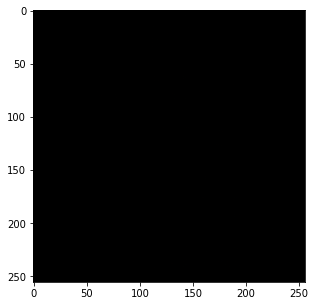

Saved sample tranformed image at rain_princess/images/sample0_0.png
========Iteration 501/10126========
	Content Loss:	4350630.50
	Style Loss:	13171630.94
	Total Loss:	17522263.63
Time elapsed:	81.71601629257202 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_500.pth


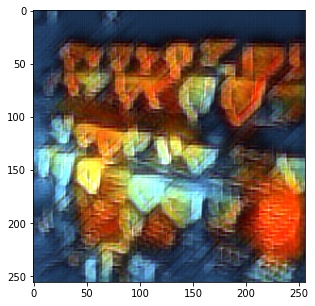

Saved sample tranformed image at rain_princess/images/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	4018899.75
	Style Loss:	7641991.78
	Total Loss:	11660894.49
Time elapsed:	162.51467156410217 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_1000.pth


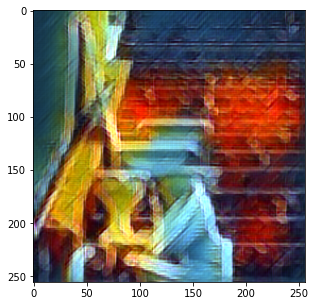

Saved sample tranformed image at rain_princess/images/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	3753424.75
	Style Loss:	5629189.04
	Total Loss:	9382613.28
Time elapsed:	241.9008150100708 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_1500.pth


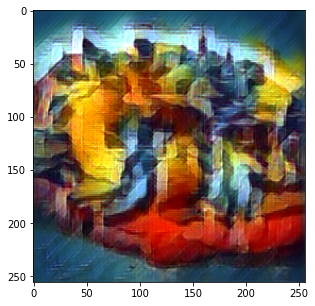

Saved sample tranformed image at rain_princess/images/sample0_1500.png
========Iteration 2001/10126========
	Content Loss:	3530874.50
	Style Loss:	4585924.43
	Total Loss:	8116800.15
Time elapsed:	320.9220805168152 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_2000.pth


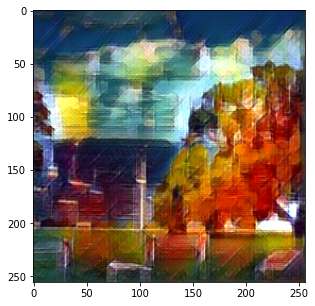

Saved sample tranformed image at rain_princess/images/sample0_2000.png
========Iteration 2501/10126========
	Content Loss:	3343870.25
	Style Loss:	3937771.27
	Total Loss:	7281642.81
Time elapsed:	399.06969594955444 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_2500.pth


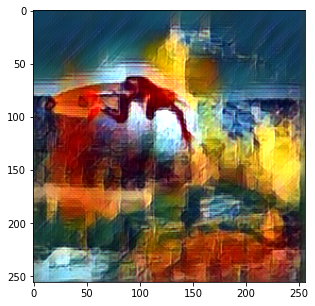

Saved sample tranformed image at rain_princess/images/sample0_2500.png
========Iteration 3001/10126========
	Content Loss:	3199218.25
	Style Loss:	3494293.71
	Total Loss:	6693513.64
Time elapsed:	476.45732378959656 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_3000.pth


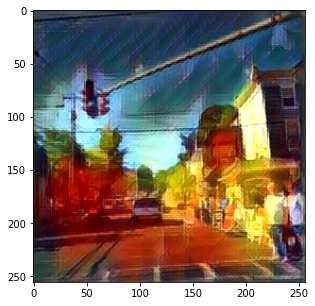

Saved sample tranformed image at rain_princess/images/sample0_3000.png
========Iteration 3501/10126========
	Content Loss:	3080702.75
	Style Loss:	3171183.96
	Total Loss:	6251887.07
Time elapsed:	553.4069964885712 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_3500.pth


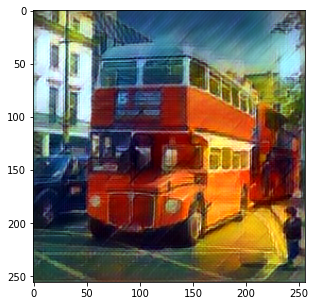

Saved sample tranformed image at rain_princess/images/sample0_3500.png
========Iteration 4001/10126========
	Content Loss:	2984581.00
	Style Loss:	2921817.44
	Total Loss:	5906397.85
Time elapsed:	629.6259541511536 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_4000.pth


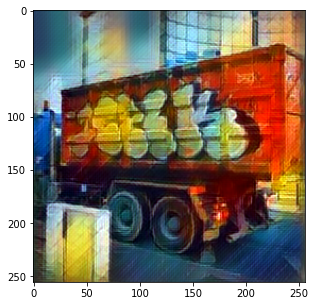

Saved sample tranformed image at rain_princess/images/sample0_4000.png
========Iteration 4501/10126========
	Content Loss:	2902291.00
	Style Loss:	2723975.93
	Total Loss:	5626266.62
Time elapsed:	705.3944535255432 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_4500.pth


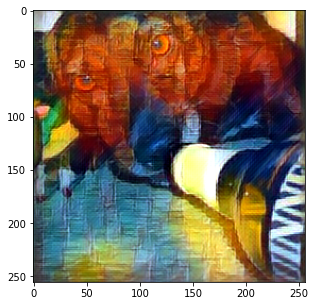

Saved sample tranformed image at rain_princess/images/sample0_4500.png
========Iteration 5001/10126========
	Content Loss:	2831267.50
	Style Loss:	2561266.66
	Total Loss:	5392533.49
Time elapsed:	780.3027834892273 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_5000.pth


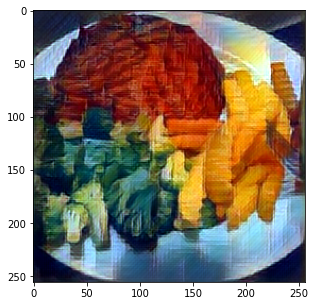

Saved sample tranformed image at rain_princess/images/sample0_5000.png
========Iteration 5501/10126========
	Content Loss:	2770416.25
	Style Loss:	2426045.22
	Total Loss:	5196459.98
Time elapsed:	854.6825938224792 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_5500.pth


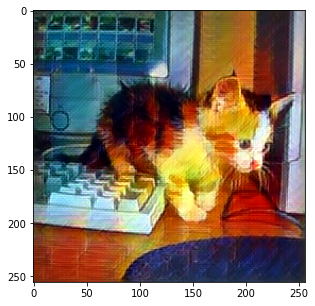

Saved sample tranformed image at rain_princess/images/sample0_5500.png
========Iteration 6001/10126========
	Content Loss:	2719017.25
	Style Loss:	2312327.03
	Total Loss:	5031343.24
Time elapsed:	928.6907210350037 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_6000.pth


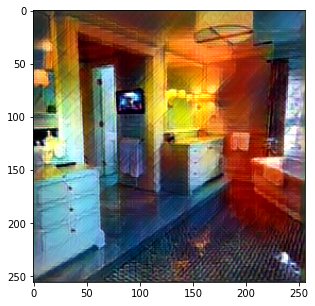

Saved sample tranformed image at rain_princess/images/sample0_6000.png
========Iteration 6501/10126========
	Content Loss:	2673490.50
	Style Loss:	2213728.02
	Total Loss:	4887217.87
Time elapsed:	1002.4380297660828 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_6500.pth


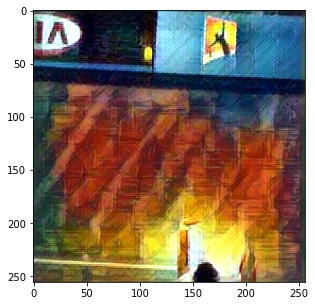

Saved sample tranformed image at rain_princess/images/sample0_6500.png
========Iteration 7001/10126========
	Content Loss:	2629724.00
	Style Loss:	2127337.85
	Total Loss:	4757061.96
Time elapsed:	1075.7584710121155 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_7000.pth


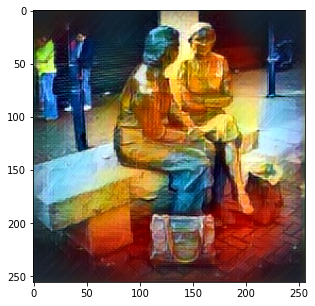

Saved sample tranformed image at rain_princess/images/sample0_7000.png
========Iteration 7501/10126========
	Content Loss:	2591982.00
	Style Loss:	2051629.84
	Total Loss:	4643610.74
Time elapsed:	1148.9769971370697 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_7500.pth


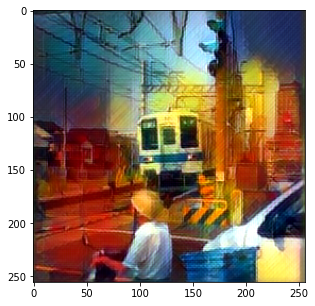

Saved sample tranformed image at rain_princess/images/sample0_7500.png
========Iteration 8001/10126========
	Content Loss:	2557553.50
	Style Loss:	1984447.86
	Total Loss:	4541995.76
Time elapsed:	1221.9779570102692 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_8000.pth


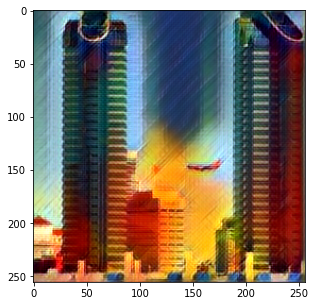

Saved sample tranformed image at rain_princess/images/sample0_8000.png
========Iteration 8501/10126========
	Content Loss:	2528010.50
	Style Loss:	1925561.04
	Total Loss:	4453567.80
Time elapsed:	1295.2033088207245 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_8500.pth


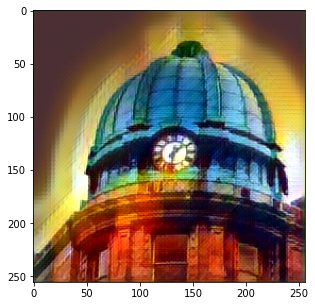

Saved sample tranformed image at rain_princess/images/sample0_8500.png
========Iteration 9001/10126========
	Content Loss:	2500530.00
	Style Loss:	1871011.90
	Total Loss:	4371538.16
Time elapsed:	1368.238828420639 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_9000.pth


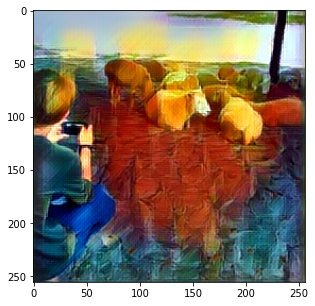

Saved sample tranformed image at rain_princess/images/sample0_9000.png
========Iteration 9501/10126========
	Content Loss:	2475775.50
	Style Loss:	1822323.98
	Total Loss:	4298095.41
Time elapsed:	1441.2053053379059 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_9500.pth


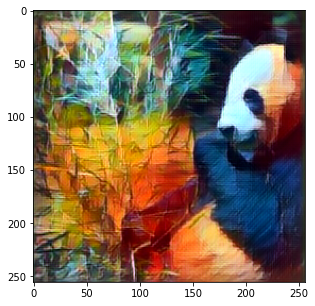

Saved sample tranformed image at rain_princess/images/sample0_9500.png
========Iteration 10001/10126========
	Content Loss:	2452122.25
	Style Loss:	1777287.01
	Total Loss:	4229406.44
Time elapsed:	1514.0737283229828 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_10000.pth


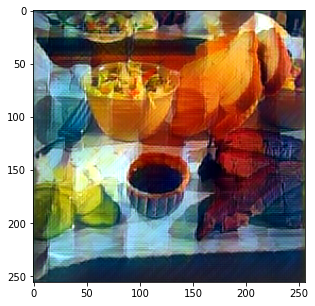

Saved sample tranformed image at rain_princess/images/sample0_10000.png
========Iteration 10126/10126========
	Content Loss:	2445851.75
	Style Loss:	1766600.98
	Total Loss:	4212449.36
Time elapsed:	1532.4312331676483 seconds
Saved TransformerNetwork checkpoint file at rain_princess/models/checkpoint_10125.pth


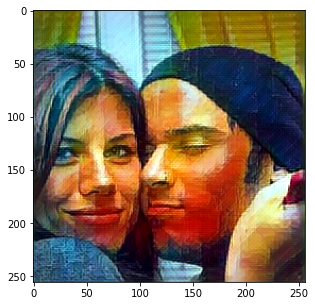

Saved sample tranformed image at rain_princess/images/sample0_10125.png
Done Training the Transformer Network!
Training Time: 1532.6353375911713 seconds
========Content Loss========
[76701360.0, 17522263.631736528, 11660894.485514486, 9382613.279813457, 8116800.150674663, 7281642.809276289, 6693513.636371209, 6251887.073121965, 5906397.851474632, 5626266.622472784, 5392533.48745251, 5196459.977685875, 5031343.24245959, 4887217.872596524, 4757061.957363234, 4643610.743367551, 4541995.761623547, 4453567.80049406, 4371538.156204866, 4298095.410325229, 4229406.435256475, 4212449.3647540985]
========Style Loss========
[73487872.0, 13171630.941117765, 7641991.777472528, 5629189.03772485, 4585924.43372064, 3937771.268592563, 3494293.7118460513, 3171183.956441017, 2921817.4375781054, 2723975.927488336, 2561266.655256449, 2426045.219176059, 2312327.0348691884, 2213728.0223523304, 2127337.8514587204, 2051629.837938275, 1984447.8644466316, 1925561.044171274, 1871011.8996708698, 1822323.9845542575

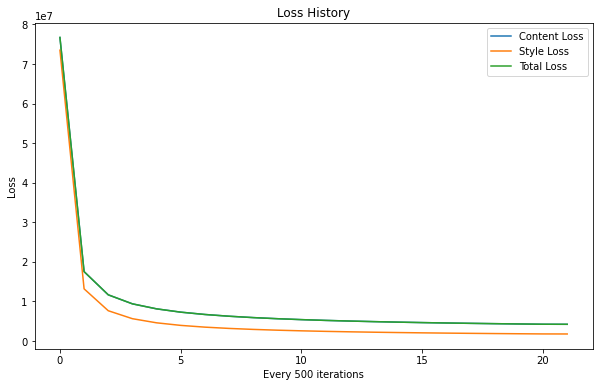

In [10]:
train()

In [11]:
# copy the models folder to the folder in the google drive
!cp -r rain_princess/models/ /content/gdrive/My\ Drive/coco/rain_princess/
# copy the images folder to the folder in the google drive
!cp -r rain_princess/images/ /content/gdrive/My\ Drive/coco/rain_princess/

## The Scream

In [12]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_scream.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_scream/models/"
SAVE_IMAGE_PATH = "the_scream/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3213490.00
	Style Loss:	25241902.00
	Total Loss:	28455392.00
Time elapsed:	0.3653287887573242 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_0.pth


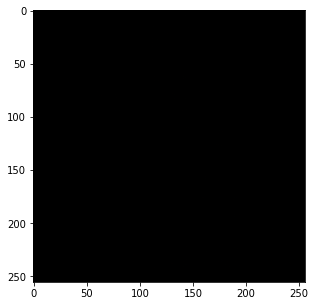

Saved sample tranformed image at the_scream/images/sample0_0.png
========Iteration 501/10126========
	Content Loss:	2079811.50
	Style Loss:	2279143.33
	Total Loss:	4358954.14
Time elapsed:	70.33098363876343 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_500.pth


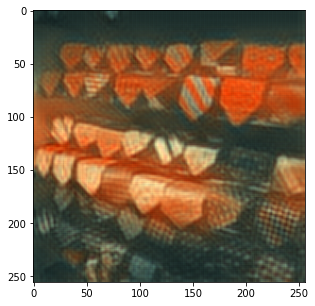

Saved sample tranformed image at the_scream/images/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	1716467.50
	Style Loss:	1392456.35
	Total Loss:	3108923.71
Time elapsed:	140.33408570289612 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_1000.pth


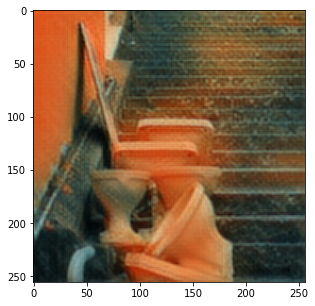

Saved sample tranformed image at the_scream/images/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	1534020.12
	Style Loss:	1087674.54
	Total Loss:	2621695.35
Time elapsed:	210.31934070587158 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_1500.pth


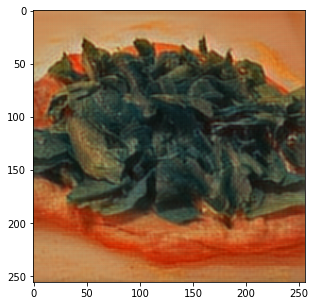

Saved sample tranformed image at the_scream/images/sample0_1500.png
========Iteration 2001/10126========
	Content Loss:	1419857.50
	Style Loss:	931302.82
	Total Loss:	2351161.47
Time elapsed:	280.2935793399811 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_2000.pth


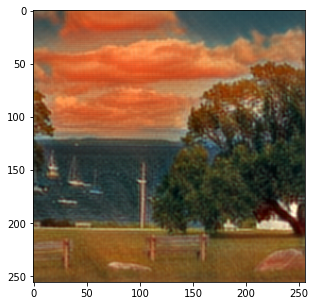

Saved sample tranformed image at the_scream/images/sample0_2000.png
========Iteration 2501/10126========
	Content Loss:	1342153.00
	Style Loss:	834423.24
	Total Loss:	2176575.86
Time elapsed:	350.28994703292847 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_2500.pth


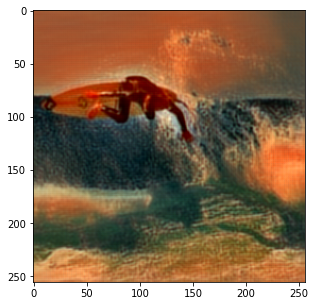

Saved sample tranformed image at the_scream/images/sample0_2500.png
========Iteration 3001/10126========
	Content Loss:	1282464.50
	Style Loss:	768318.57
	Total Loss:	2050782.54
Time elapsed:	420.3062274456024 seconds
Saved TransformerNetwork checkpoint file at the_scream/models/checkpoint_3000.pth


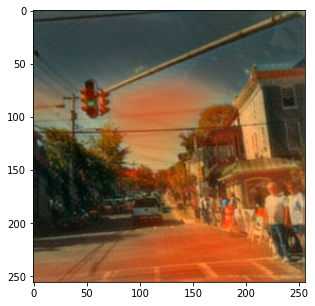

Saved sample tranformed image at the_scream/images/sample0_3000.png


In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r the_scream/models/ /content/gdrive/My\ Drive/coco/the_scream/models
# copy the images folder to the folder in the google drive
!cp -r the_scream/images/ /content/gdrive/My\ Drive/coco/the_scream/images

## The Shipwreck

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_shipwreck.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_shipwreck/models/"
SAVE_IMAGE_PATH = "the_shipwreck/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r the_shipwreck/models/ /content/gdrive/My\ Drive/coco/the_shipwreck/models
# copy the images folder to the folder in the google drive
!cp -r the_shipwreck/images/ /content/gdrive/My\ Drive/coco/the_shipwreck/images

## Udnie

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/udnie.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "udnie/models/"
SAVE_IMAGE_PATH = "udnie/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/coco/udnie/models
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/coco/udnie/images

## Wave

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/wave.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "wave/models/"
SAVE_IMAGE_PATH = "wave/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r wave/models/ /content/gdrive/My\ Drive/coco/wave/models
# copy the images folder to the folder in the google drive
!cp -r wave/images/ /content/gdrive/My\ Drive/coco/wave/images